Using device: cuda
Loading PneumoniaMNIST dataset...


100%|██████████| 4.17M/4.17M [00:01<00:00, 2.85MB/s]


Dataset loaded successfully.
Training set size: 4708
Validation set size: 524
Test set size: 624

Analyzing class distribution in the training set...
Class counts: Normal (0): 1214, Pneumonia (1): 3494

Initializing ResNet-50 model for transfer learning...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


Model initialized.

Starting model training...
Epoch [1/20], Loss: 0.4072, Val Accuracy: 0.8454, Val AUC: 0.9452
New best model saved with Val AUC: 0.9452
Epoch [2/20], Loss: 0.2885, Val Accuracy: 0.8473, Val AUC: 0.9497
New best model saved with Val AUC: 0.9497
Epoch [3/20], Loss: 0.2611, Val Accuracy: 0.8855, Val AUC: 0.9550
New best model saved with Val AUC: 0.9550
Epoch [4/20], Loss: 0.2484, Val Accuracy: 0.9008, Val AUC: 0.9572
New best model saved with Val AUC: 0.9572
Epoch [5/20], Loss: 0.2244, Val Accuracy: 0.9008, Val AUC: 0.9593
New best model saved with Val AUC: 0.9593
Epoch [6/20], Loss: 0.2327, Val Accuracy: 0.9008, Val AUC: 0.9595
New best model saved with Val AUC: 0.9595
Epoch [7/20], Loss: 0.2108, Val Accuracy: 0.9084, Val AUC: 0.9617
New best model saved with Val AUC: 0.9617
Epoch [8/20], Loss: 0.2009, Val Accuracy: 0.8760, Val AUC: 0.9628
New best model saved with Val AUC: 0.9628
Epoch [9/20], Loss: 0.2026, Val Accuracy: 0.9103, Val AUC: 0.9640
New best model saved wi

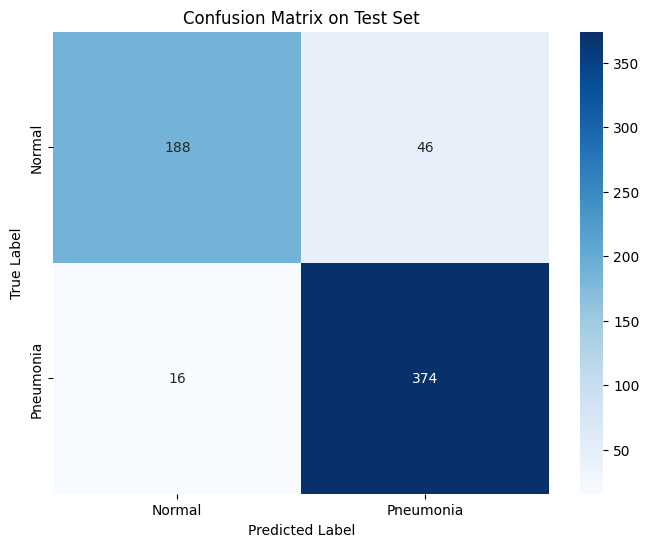

In [ ]:
# pneumonia_classification.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import medmnist
from medmnist import PneumoniaMNIST

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings from medmnist library
warnings.filterwarnings("ignore", category=UserWarning)

# HYPERPARAMETER CHOICES
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2 # Pneumonia vs. Normal

def main():

    print(f"Using device: {DEVICE}")

    #DATA PREPARATION
    data_transform_train = transforms.Compose([
            transforms.ToTensor(),
            lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Resize((224, 224)), # ResNet-50, 224x224 input
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    data_transform_val_test = transforms.Compose([
            transforms.ToTensor(),
            lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # Download and load the datasets
    print("Loading PneumoniaMNIST dataset...")
    train_dataset = PneumoniaMNIST(split='train', transform=data_transform_train, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=data_transform_val_test, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=data_transform_val_test, download=True)

    print("Dataset loaded successfully.")
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # CLASS IMBALANCE HANDLING
    print("\nAnalyzing class distribution in the training set...")
    labels = train_dataset.labels.flatten()
    class_counts = np.bincount(labels)
    print(f"Class counts: Normal (0): {class_counts[0]}, Pneumonia (1): {class_counts[1]}")

    class_weights = 1. / class_counts
    sample_weights = np.array([class_weights[label] for label in labels])
    sample_weights = torch.from_numpy(sample_weights).double()

    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # MODEL DEFINITION
    print("\nInitializing ResNet-50 model for transfer learning...")
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    # Freeze all layers except the final classification layer
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the classifier
    num_ftrs = model.fc.in_features

    # Replace the final fully connected layer
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(DEVICE)
    print("Model initialized.")

    # TRAINING CONFIGURATION
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE) # Only optimize the new layer

    # TRAINING LOOP
    best_val_auc = 0
    best_model_state = None

    print("\nStarting model training...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(DEVICE)
            labels = labels.squeeze().long().to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        val_metrics = evaluate_model(model, val_loader, DEVICE)
        val_auc = val_metrics['auc']
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Accuracy: {val_metrics['accuracy']:.4f}, Val AUC: {val_auc:.4f}")

        # Save the best model based on validation AUC
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict()
            print(f"New best model saved with Val AUC: {best_val_auc:.4f}")

    print("Training finished.")

    # FINAL EVALUATION
    print("\nLoading best model for final evaluation on the test set...")
    model.load_state_dict(best_model_state)
    test_metrics = evaluate_model(model, test_loader, DEVICE, is_test=True)

    print("\n--- Evaluation Metrics Justification ---")
    print("1. Accuracy: Overall correctness. Good for a baseline but can be misleading with imbalanced data.")
    print("2. Precision/Recall/F1-Score: Crucial for medical diagnosis. High Recall is vital to not miss pneumonia cases (minimize false negatives). Precision minimizes false alarms.")
    print("3. AUC-ROC: Measures the model's ability to distinguish between classes across all thresholds. It's robust to class imbalance and provides a comprehensive view of performance.")


    print("\n--- Test Set Performance ---")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1-Score: {test_metrics['f1_score']:.4f}")
    print(f"AUC-ROC: {test_metrics['auc']:.4f}")


def evaluate_model(model, data_loader, device, is_test=False):
    """
    Evaluates the model on a given dataset.
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)[:, 1] # Probability of class 1 (Pneumonia)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }

    # If it's the final test evaluation, plot the confusion matrix
    if is_test:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Pneumonia'],
                    yticklabels=['Normal', 'Pneumonia'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix on Test Set')
        plt.savefig('confusion_matrix.png')
        print("\nConfusion matrix saved as 'confusion_matrix.png'")


    return metrics

if __name__ == '__main__':
    main()

In [ ]:
! pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha25